In [80]:
# import sys
# sys.path.append(r'C:\Users\edwar\Documents\LabStuff\ibllib\brainbox\io')
import matplotlib.pyplot as plt
import numpy as np
from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.raw_data_loaders import *
#from ibllib.pipes.tasks import *
from ibllib.pipes import *
from ibllib.io.extractors.bpod_trials import *
from one.api import ONE
from ONE.one.alf.io import *

from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times
from localAlf import load_wheel_reaction_times_local

In [ ]:
session_path = r'I:\Cerebellum_Imaging_Project\iblrig_data\J_R2_1005832\2023-08-28\002'
bpod_data = load_data(session_path)
#stim_pos = load_stim_position_screen(session_path)
encoder_events = load_encoder_events(session_path)
encoder_pos = load_encoder_positions(session_path)

In [ ]:
trials, wheel, output_files = extract_all(session_path, save=True)

In [ ]:
wheel= load_object(session_path+'\\alf', 'wheel')



In [ ]:
wheel_moves = extract_wheel_moves(wheel.timestamps, wheel.position)

### The movements algorithm
The wheel movement onsets and offsets are calculated using the `wheel.movements` function.  The output of this function is saved in the 'wheelMoves' ALF.

Refer to the `wheel.movements` function docstring for details of how the movements are detected.  In addition to the data found in the wheelMoves object, the function outputs an array of peak velocity times.  Also the function has a `make_plots` flag which will produce plots of the wheel position and velocity with the movement onsets and offsets highlighted (see below).

The movements algorithm requires the positions and timestamps to be evenly sampled so they should be interpolated first, which can be done with the `wheel.interpolate_position` function.  The default sampling frequency is 1000Hz:

In [ ]:
pos, t = wh.interpolate_position(wheel.timestamps, wheel.position)
sec = 1000  # Number of seconds to plot
plt.figure()

# Plot the interpolated data points
mask = t < (t[0] + sec)
plt.plot(t[mask], pos[mask], '.', markeredgecolor='lightgrey', markersize=1)

# Plot the original data
mask = wheel.timestamps < (wheel.timestamps[0] + sec)
plt.plot(wheel.timestamps[mask], wheel.position[mask], 'r+', markersize=6)

# Labels etc.
plt.xlabel('time / sec')
plt.ylabel('position / rad')
plt.box(on=None)
plt.show()

In [ ]:
# Convert the pos threshold defaults from samples to correct unit
thresholds_cm = wh.samples_to_cm(np.array([8, 1.5]), resolution=wh.ENC_RES)
thresholds = wh.cm_to_rad(thresholds_cm)
mask = t < (t[0] + sec)

onsets, offsets, peak_amp, peak_vel_times = wh.movements(
    t[mask], pos[mask], pos_thresh=thresholds[0], pos_thresh_onset=thresholds[0], make_plots=True)
plt.show()

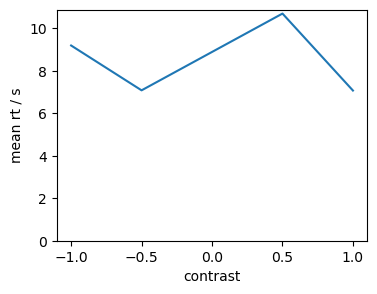

In [81]:
rt = load_wheel_reaction_times_local(session_path+'\\alf')
trial_data = load_object(session_path+'\\alf', 'trials')

# # Replace nans with zeros
trial_data.contrastRight[np.isnan(trial_data.contrastRight)] = 0
trial_data.contrastLeft[np.isnan(trial_data.contrastLeft)] = 0

contrast = trial_data.contrastRight - trial_data.contrastLeft
mean_rt = [np.nanmean(rt[contrast == c]) for c in set(contrast)]

# RT may be nan if there were no detected movements, or if the goCue or stimOn times were nan
xdata = np.unique(contrast)
plt.figure(figsize=(4, 3))  # Some sort of strange behaviour in this cell's output
plt.plot(xdata, mean_rt);

plt.xlabel('contrast')
plt.ylabel('mean rt / s')
plt.ylim(bottom=0);
plt.show()

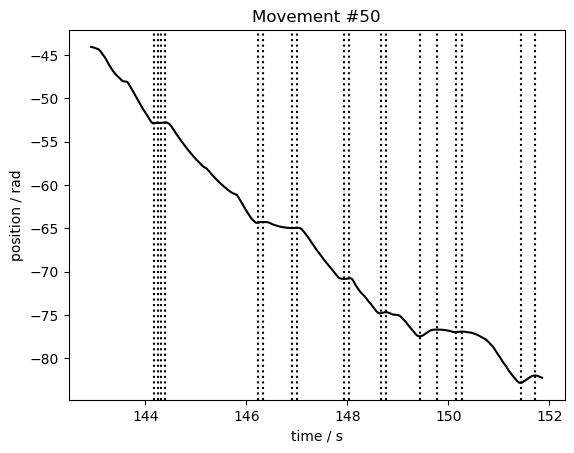

In [85]:
Fs = 1000
pos, t = wh.interpolate_position(wheel.timestamps, wheel.position, freq=Fs)
vel, acc = wh.velocity_smoothed(pos, Fs)
n = 50
on, off = wheel_moves['intervals'][n,]
mask = np.logical_and(t > on, t < off)
sng = np.sign(vel[mask])
idx, = np.where(np.diff(sng) != 0)

plt.figure()
plt.plot(t[mask], pos[mask], 'k')
for i in idx:
    plt.axvline(x=t[mask][i], color='k', linestyle=':')

plt.title('Movement #%s' % n)
plt.xlabel('time / s')
plt.ylabel('position / rad');
plt.show()

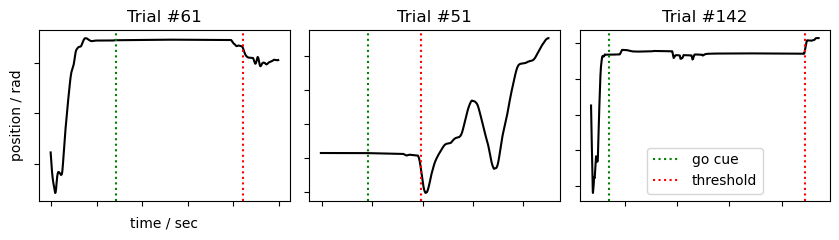

In [86]:
n_trials = 3  # Number of trials to plot
# Randomly select the trials to plot
trial_ids = np.random.randint(trial_data['choice'].size, size=n_trials)
fig, axs = plt.subplots(1, n_trials, figsize=(8.5,2.5))
plt.tight_layout()

# Plot go cue and response times
goCues = trial_data['goCue_times'][trial_ids]
responses = trial_data['response_times'][trial_ids]

# Plot traces between trial intervals
starts = trial_data['intervals'][trial_ids, 0]
ends = trial_data['intervals'][trial_ids, 1]
# Cut up the wheel vectors
traces = wh.traces_by_trial(t, pos, start=starts, end=ends)
zipped = zip(traces, axs, goCues, responses, trial_ids)

for (trace, ax, go, resp, n) in zipped:
    ax.plot(trace[0], trace[1], 'k-')
    ax.axvline(x=go, color='g', label='go cue', linestyle=':')
    ax.axvline(x=resp, color='r', label='threshold', linestyle=':')
    ax.set_title('Trial #%s' % n)

    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# Add labels to first
axs[0].set_xlabel('time / sec')
axs[0].set_ylabel('position / rad')
plt.legend();
plt.tight_layout()
plt.show()